In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [41]:
med,le,he = np.zeros([3,10])
for i in range(10):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_Pm{0}.npy'.format(i+1))
    med[i],le[i],he[i] = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Pa.npy')
a,ale,ahe = Highest_density_region(px,x)

time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9)

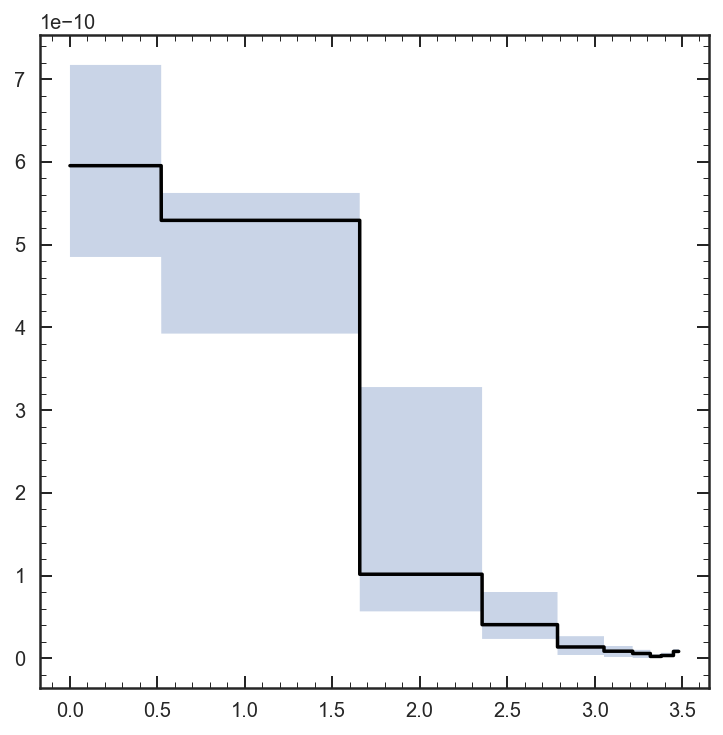

In [42]:
plt.figure(figsize=[6,6])
plt.plot(time,sfr,'k')
# plt.plot(time,sfr_l,'k')
# plt.plot(time,sfr_h,'k')
plt.fill_between(time,sfr_l, sfr_h, alpha = 0.3)


In [95]:
MB = [0]
T=[0]
m=0
IMB = []
for i in range(len(time)//2):
    m+=sfr[i*2+1] * (time[i*2+1] - time[i*2])
    IMB.append(sfr[i*2+1] * (time[i*2+1] - time[i*2]))
    MB.append(m)
    T.append(time[i*2+1])

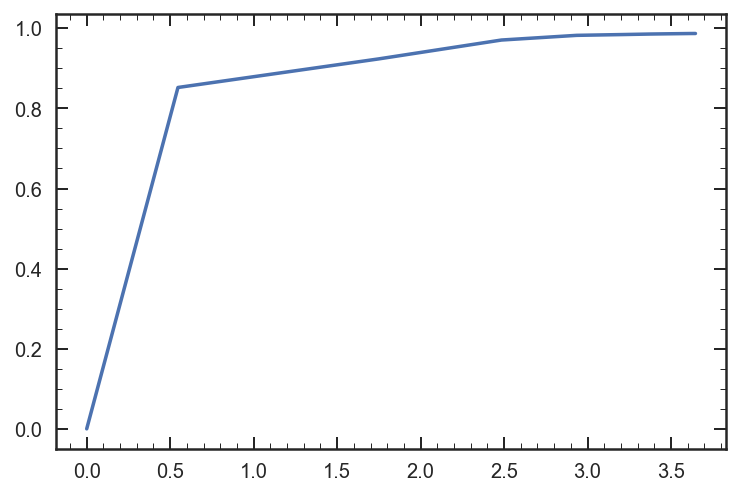

In [101]:
plt.plot(T,MB)

In [97]:
sum(IMB[1:])

0.13479114941362091

In [98]:
newx = np.arange(T[1],T[-1]+0.001,0.001)
tau = np.arange(0.001,1,0.001)

mass = []
for i in tau: 
    k = sfr[1] / max(np.exp(-newx / i))
    expfit = np.exp(-newx / i) * k
    mass.append(np.trapz(expfit,newx))
#     plt.plot(newx, expfit)
#     plt.plot(time,sfr ,'k')


array(0.08640263)

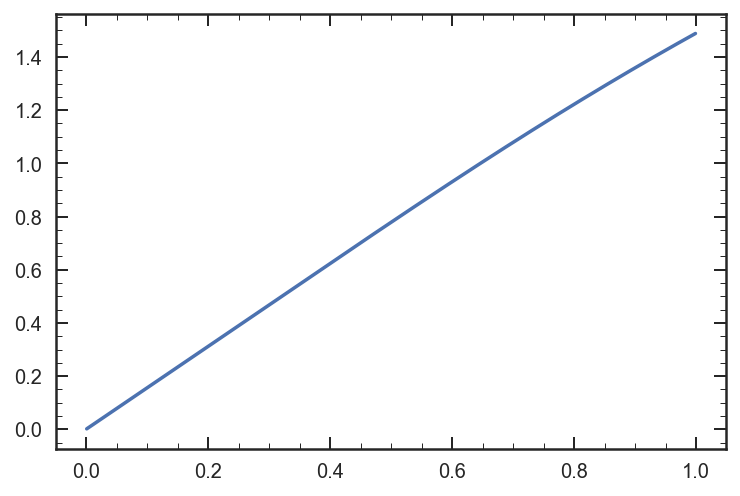

In [99]:
plt.plot(tau,mass)
interp1d(mass,tau)(sum(IMB[1:]))

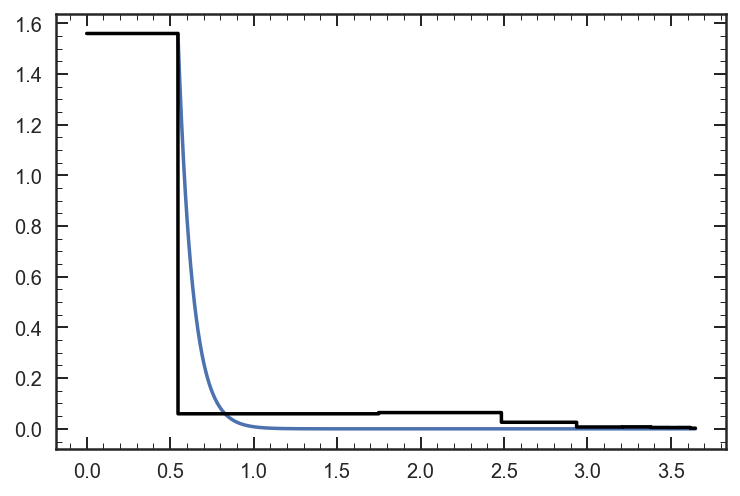

In [100]:
outtau = interp1d(mass,tau)(sum(IMB[1:]))
k = sfr[1] / max(np.exp(-newx /outtau))
expfit = np.exp(-newx / outtau) * k
plt.plot(newx, expfit)
plt.plot(time,sfr ,'k')

In [29]:
def Get_tau(field, galaxy):
    
    med = np.zeros(10)
    for i in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(field, galaxy, i+1))
        med[i] = x[px == px.max()][0]

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(field, galaxy))
    a = x[px == px.max()][0]

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    
    T=[0]
    IMB = []
    for i in range(len(time)//2):
        IMB.append(sfr[i*2+1] * (time[i*2+1] - time[i*2]))
        T.append(time[i*2+1])
    
#     newx = np.arange(T[1],T[-1]+0.001,0.001)
#     tau = np.arange(0.001,1,0.001)

#     mass = []
#     for i in tau: 
#         k = sfr[1] / max(np.exp(-newx / i))
#         expfit = np.exp(-newx / i) * k
#         mass.append(np.trapz(expfit,newx))

#     return interp1d(mass,tau)(sum(IMB[1:]))
    return 1-sum(IMB[1:]) / sum(IMB)


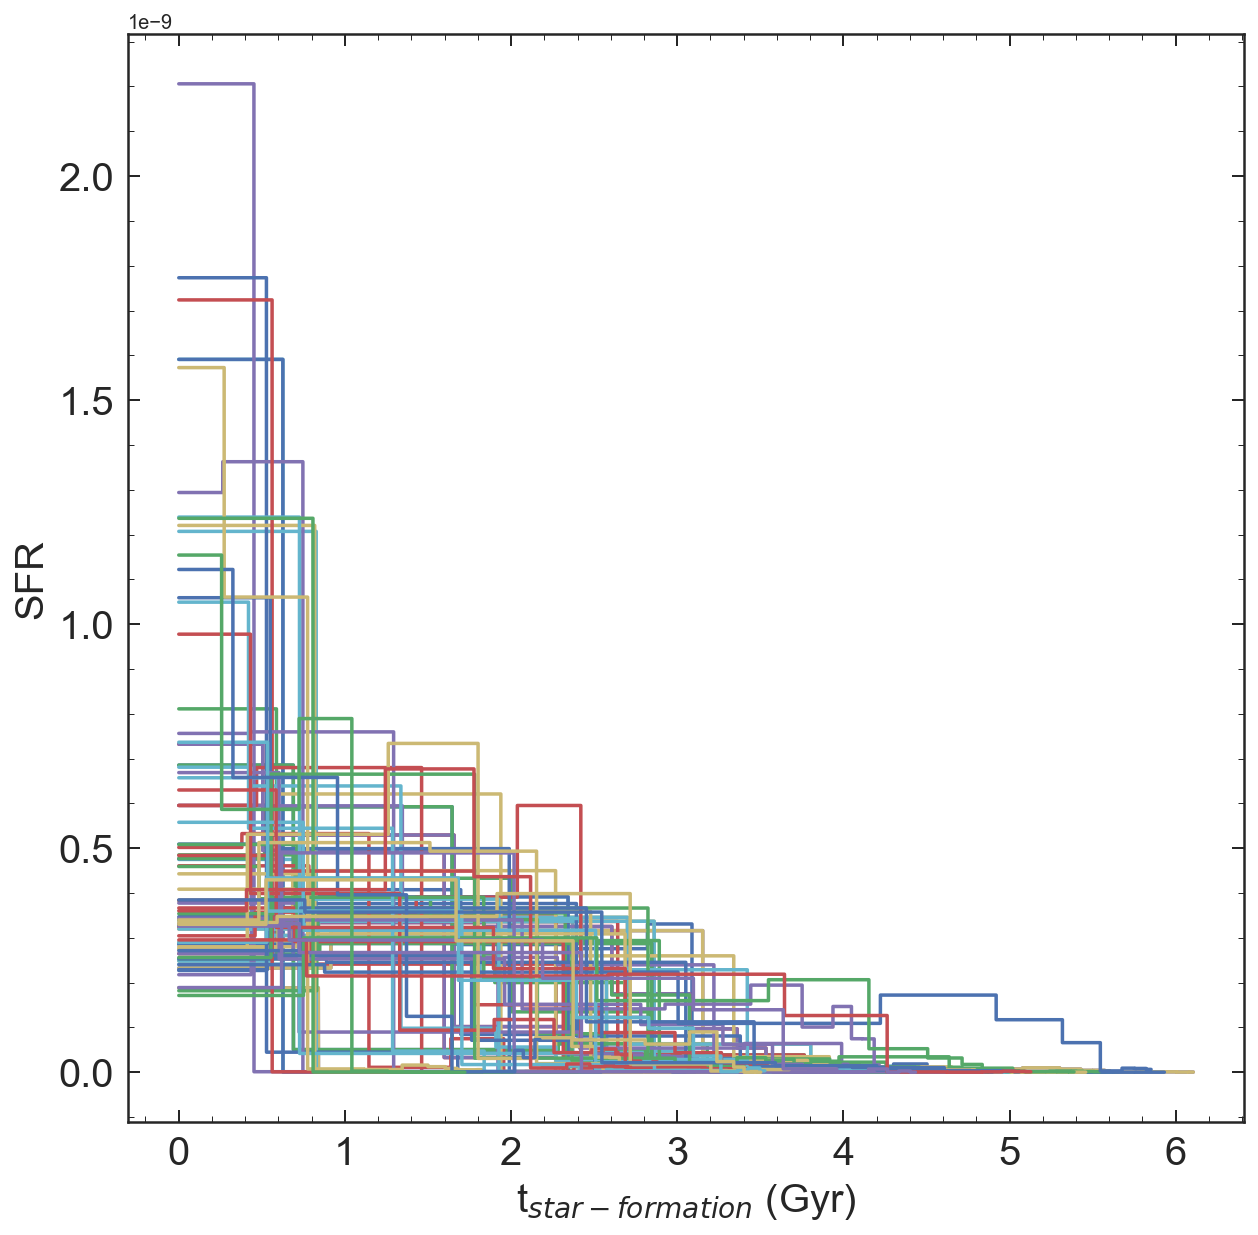

In [46]:
plt.figure(figsize = [10,10])
for i in range(len(fld)):
    med = np.zeros(10)
    for ii in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(fld[i], ids[i], ii+1))
        med[ii] = x[px == px.max()][0]

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(fld[i], ids[i]))
    a = x[px == px.max()][0]

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    
    plt.plot(time,sfr)
plt.xlabel('t$_{star-formation}$ (Gyr)', fontsize=20)
plt.ylabel('SFR', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/all_sfr.png' ,bbox_inches = 'tight')


# get size

In [2]:
goodss_rad = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodsn_rad = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
# goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
# goodss_fast = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
# goodsn_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
# goodsn_fast = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()


In [4]:
goodss_rad

,NUMBER,RA,DEC,f,mag,dmag,re,dre,n,dn,q,dq,pa,dpa,sn
0,1,53.093014,-27.954546,2,19.4883,0.007386,1.882780,1.810330e-02,8.0000,0.115835,0.3111,0.003598,-14.8062,0.353449,5.753920e+02
1,2,53.089611,-27.959742,2,23.2500,0.982590,12.226500,1.613200e+01,4.1751,7.276290,0.0627,0.345203,63.3197,35.800200,5.003430e+00
2,3,53.102913,-27.959642,2,18.8000,0.000003,0.018000,8.569490e-08,3.7612,0.000043,0.0390,0.000004,11.1997,0.000530,1.111810e+06
3,4,53.101707,-27.958481,2,18.6500,0.025556,24.000000,7.534290e-01,8.0000,0.364663,0.0500,0.010676,-19.6032,0.993278,1.639300e+02
4,5,53.102276,-27.958683,2,27.8800,0.102467,0.175398,3.838960e-02,8.0000,2.428890,0.9900,0.101329,60.2812,14.523400,2.243470e+01
5,6,53.090576,-27.958515,2,25.2701,0.269425,0.311190,1.144620e-01,0.2000,0.215984,0.4716,0.212584,-33.8795,23.068200,7.401020e+00
6,7,53.099964,-27.958279,0,23.6813,0.062219,0.294024,2.164530e-02,0.8942,0.200557,0.4632,0.047783,-77.1846,3.492410,3.858540e+01
7,8,53.096142,-27.957582,1,21.5818,0.021024,1.284380,2.463640e-02,0.7264,0.031897,0.1494,0.010204,-77.1472,0.730478,1.327760e+02
8,9,53.091572,-27.958366,2,25.6259,0.398363,0.161604,1.328840e-01,6.9430,9.103480,0.0417,0.425464,58.9721,51.572900,6.531030e+00
9,10,53.091854,-27.958181,0,25.5008,0.291031,0.173154,8.746120e-02,1.2117,1.528160,0.6985,0.363178,29.0576,35.736200,7.066120e+00


In [94]:
flist = glob('../data/posteriors/G*tabfit_Plm*')

fld = [os.path.basename(U).split('_')[0] for U in flist] 
ids = np.array([os.path.basename(U).split('_')[1] for U in flist]).astype(int)

In [4]:
len(ids)

81

In [95]:
mass_perc = []
Reff = []
Rpc = []
lmass = []
rshift = []
lwa = []
llist = glob('../data/posteriors/G*_tabfit_Plm.npy')
zlist = glob('../data/posteriors/G*_tabfit_Pz.npy')
lwalist =  glob('../data/posteriors/G*_tabfit_Plwa.npy')
for i in range(len(fld)):
#     mass_perc.append(Get_tau(fld[i],ids[i]))
    
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(fld[i],ids[i]))
    rshift.append(x[px==px.max()][0])
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plm.npy'.format(fld[i],ids[i]))
    lmass.append(x[px==px.max()][0])
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(fld[i],ids[i]))
    lwa.append(x[px==px.max()][0])
    
    if fld[i][1] == 'S':
        r = goodss_rad.re[goodss_rad.NUMBER == ids[i]].values /2 * np.sqrt(goodss_rad.q[goodss_rad.NUMBER == ids[i]].values)
        Reff.append(r[0] )
        Rpc.append(r[0]/cosmo.arcsec_per_kpc_comoving(rshift[i]).value)
    if fld[i][1] == 'N':
        r = goodsn_rad.re[goodsn_rad.NUMBER == ids[i]].values/2 * np.sqrt(goodsn_rad.q[goodsn_rad.NUMBER == ids[i]].values)
        Reff.append(r[0])
        Rpc.append(r[0]/cosmo.arcsec_per_kpc_comoving(rshift[i]).value)

    

In [96]:
# mass_perc = np.array(mass_perc)
Reff = np.array(Reff)
Rpc = np.array(Rpc)
rshift = np.array(rshift)
lmass = np.array(lmass)
lwa = np.array(lwa)

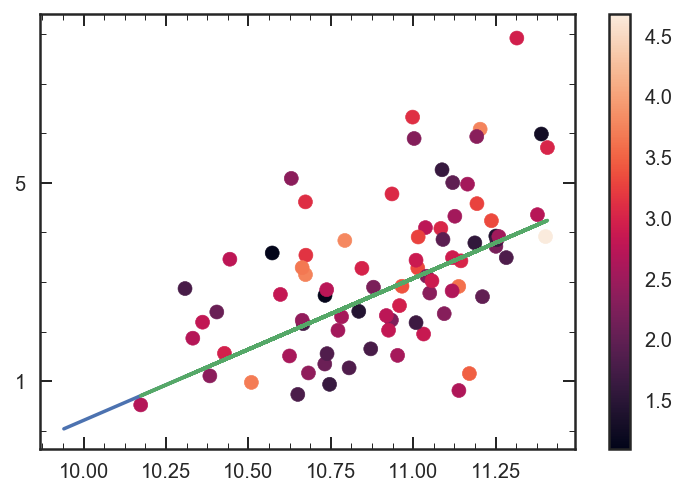

In [97]:
plt.scatter(lmass,np.log10(Rpc), c = lwa)
plt.yticks([np.log10(1),np.log10(5)],[1,5])
plt.plot([9.94,11.35], np.log10([0.68, 3.45]))
plt.plot(lmass, m*lmass - 5.14)
plt.colorbar()

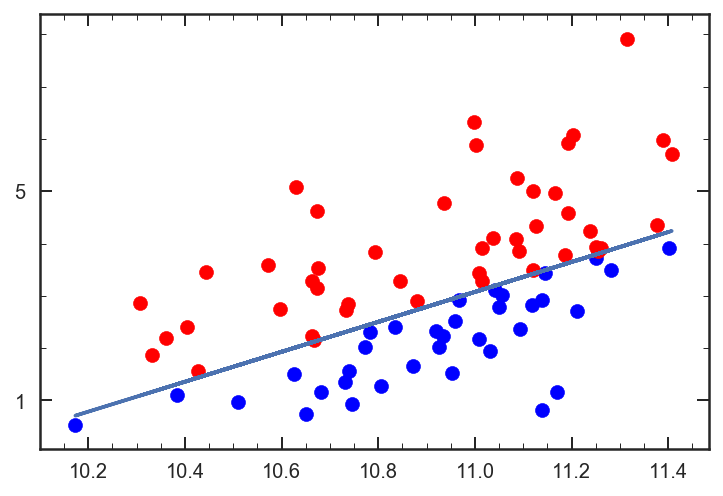

In [98]:
# plt.scatter(lmass,np.log10(Rpc), c = lwa)
plt.yticks([np.log10(1),np.log10(5)],[1,5])
for i in range(len(lmass)):
    if np.log10(Rpc[i]) > m*lmass[i] - 5.14:
        plt.scatter(lmass[i],np.log10(Rpc[i]), color = 'r')
    else:
        plt.scatter(lmass[i],np.log10(Rpc[i]), color = 'b')
        


plt.plot(lmass, m*lmass - 5.14)
# plt.colorbar()

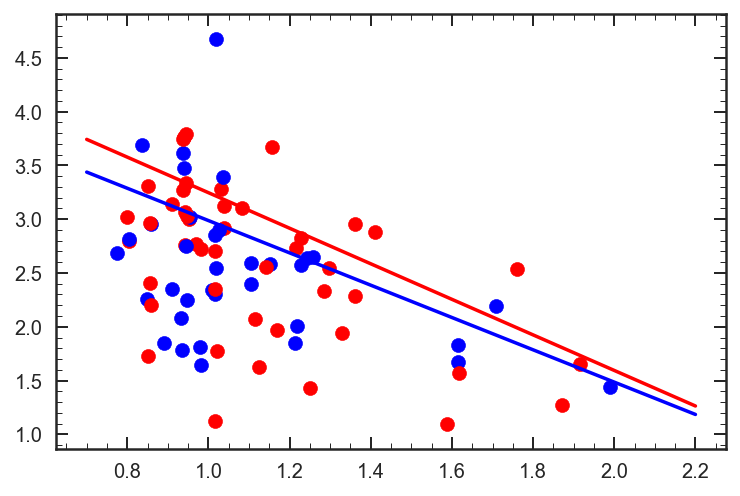

In [99]:
cz = []
clwa = []

ez = []
elwa = []

for i in range(len(lmass)):
    if np.log10(Rpc[i]) > m*lmass[i] - 5.14:
        cz.append(rshift[i])
        clwa.append(lwa[i])
        plt.scatter(rshift[i],lwa[i], color = 'r')
    else:
        ez.append(rshift[i])
        elwa.append(lwa[i])
        plt.scatter(rshift[i],lwa[i], color = 'b')

plt.plot(redshifts, cline, 'b')
plt.plot(redshifts, eline, 'r')

In [84]:
redshifts = np.arange(0.7, 2.2, 0.1)

cparam = np.polyfit(cz,clwa,1)
cline = np.polyval(cparam,redshifts)

eparam = np.polyfit(ez,elwa,1)
eline = np.polyval(eparam,redshifts)

In [ ]:
np.log10(10**9.94 / 0.68)
np.log10(10**11.35 / 3.45)

In [62]:
m = (np.log10(3.45) - np.log10(0.68)) / (11.35 -  9.94)

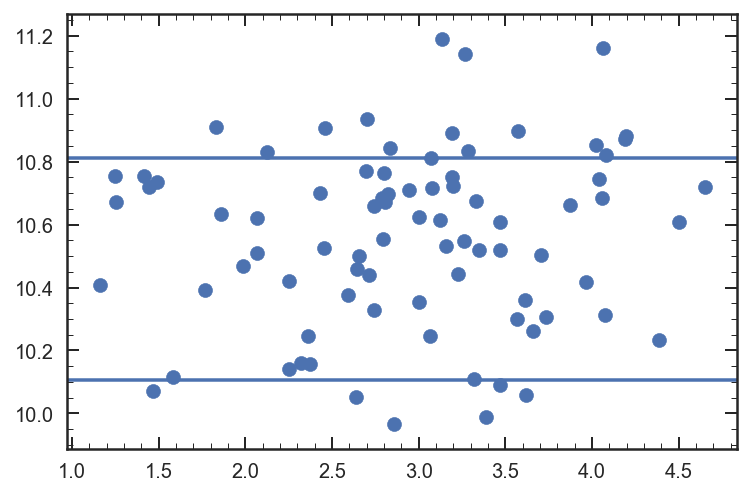

In [49]:
plt.scatter(lwa,np.log10(10**lmass/Rpc))
plt.axhline(np.log10(10**9.94 / 0.68))
plt.axhline(np.log10(10**11.35 / 3.45))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


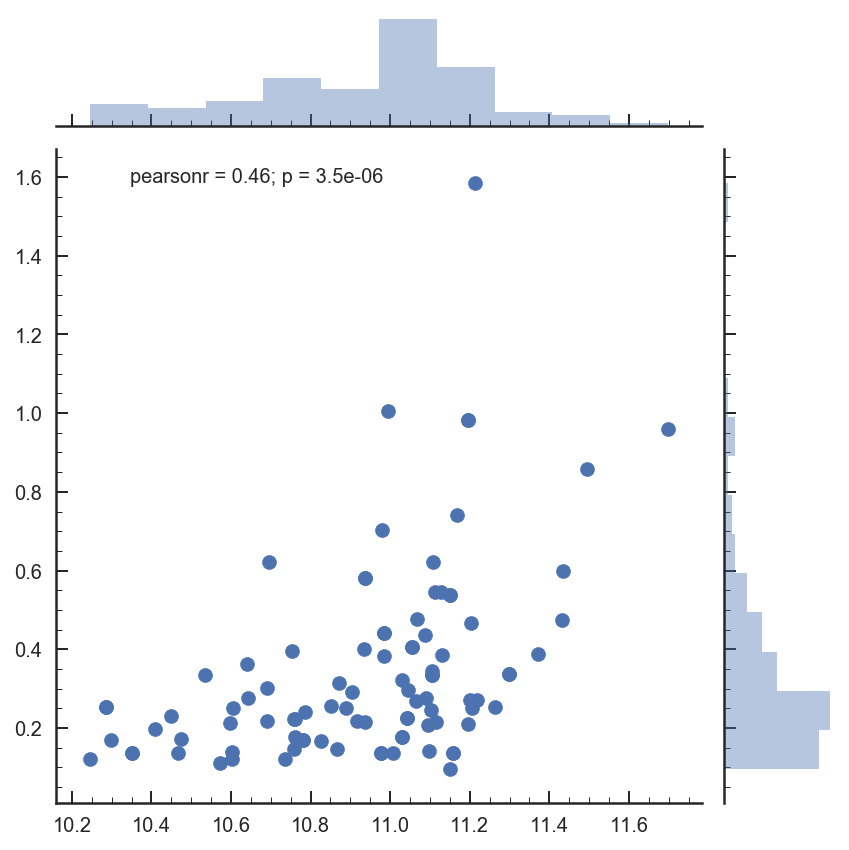

In [40]:
sea.jointplot(lmass[,Reff[Reff<2])


In [20]:
np.log10(10**lmass/Reff)

array([11.40293358, 11.37336493, 11.01120155, 11.68941076, 11.68941076,
       11.08248533, 11.51141513, 11.582297  , 11.582297  , 10.88228641,
       10.88228641, 11.78378016, 11.78378016, 12.16390753, 11.44620061,
       11.44620061, 11.21717913, 11.21717913, 11.84464299, 11.84464299,
       11.77247196, 11.77247196, 12.02635267, 12.02635267, 11.33996607,
       11.33996607, 11.5515996 , 11.5515996 , 11.65089029, 11.42006739,
       11.42006739, 11.48863306, 11.15987726, 11.34998859, 11.20318616,
       11.20318616, 11.17179636, 11.17179636, 11.43787543, 11.15556424,
       11.77657226, 11.56802343, 11.57389055, 11.44815674, 11.65600508,
       11.46027925, 11.40964888, 11.2107596 , 11.56043506, 11.3893114 ,
       11.24168005, 11.59138202, 11.7093221 , 11.13421374, 11.08586497,
       11.58135807, 11.20376232, 11.52308464, 11.71700847, 11.60129722,
       11.78352648, 11.53490474, 11.40088633, 11.32814789, 11.75436564,
       11.4112895 , 11.26957494, 11.85842345, 11.3902553 , 11.60

In [57]:
def Get_massbuildup(field, galaxy):
    med = np.zeros(10)
    for i in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(field, galaxy, i+1))
        med[i] = x[px == px.max()][0]

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(field, galaxy))
    a = x[px == px.max()][0]

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    
    T=[0]
    M =[0]
    m=0
    for i in range(len(time)//2):
        m += sfr[i*2+1] * (time[i*2+1] - time[i*2])*1E9
        M.append(m)
        T.append(time[i*2+1])
    return T, M / M[-1]


def Get_sfh(field, galaxy):
    med = np.zeros(10)
    for i in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(field, galaxy, i+1))
        med[i] = x[px == px.max()][0]
        
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(field, galaxy))
    a = x[px == px.max()][0]

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    
    T=[0]
    M =[0]
    m=0
    for i in range(len(time)//2):
        m += sfr[i*2+1] * (time[i*2+1] - time[i*2])*1E9
        M.append(m)
        T.append(time[i*2+1])
        
    return time, sfr / M[-1]

In [24]:
llist = glob('../data/posteriors/G*_tabfit_Plm.npy')


In [30]:
field = [os.path.basename(U).split('_')[0] for U in llist]
gid = [int(os.path.basename(U).split('_')[1]) for U in llist]

In [80]:
onebin = []
rshift = []
param = []
for i in range(len(field)):
    t, mb = Get_massbuildup(field[i], gid[i])
    
#     if mb[1] > 0.8:
#         print(gid[i])
#         time,sfr = Get_sfh(field[i], gid[i])
#         plt.plot(time,sfr)
    z, pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field[i], gid[i]))
    rshift.append(z[pz == max(pz)][0])

    x, px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm.npy'.format(field[i], gid[i]))
    param.append(x[px == max(px)][0])

    onebin.append(mb[1])

(0, 1.1)

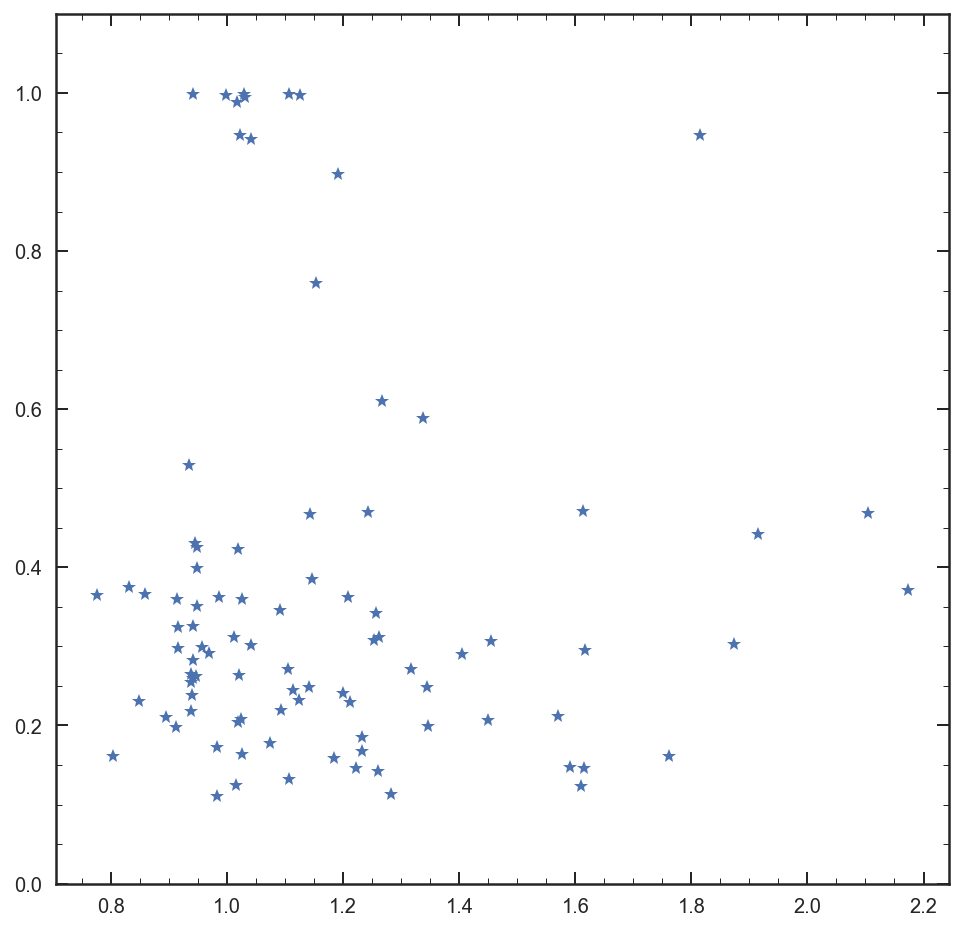

In [78]:
plt.figure(figsize=[8,8])
plt.plot(rshift,onebin,'*')
plt.ylim(0,1.1)

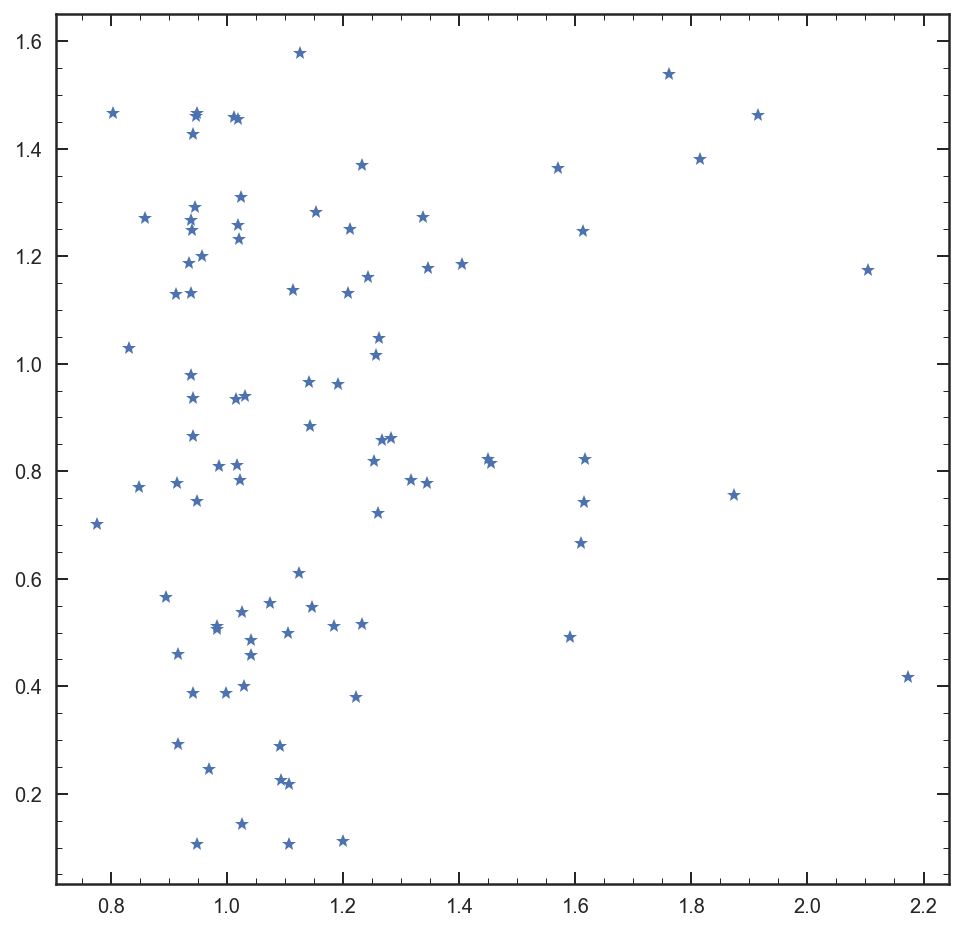

In [81]:
plt.figure(figsize=[8,8])
plt.plot(rshift,param,'*')
# plt.ylim(0,1.1)

In [42]:
sum(mb[:3])

0.8940962299891017